Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

"""from model.modeloptimization import bij_transform, bij_transform_inv, calc_mse, calc_random_walk_loss, calc_prior_loss
from model.modelinitialisierung import initialize_observations, initialize_epsilon"""
from model.modelcore import epid_model

from model.modelhelper import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


## Optimization Settings

In [3]:
start_time='2020-02-26'
end_time='2021-01-31'
observations=['Confirmed_cases', 'Admissions_hospital'] # ['Number_of_deaths', 'Confirmed_cases', 'Admissions_hospital']

dtype = torch.float32
device = torch.device("cuda:0") #cuda:0

## Initialize Observations

In [4]:
df_obs_initial = pd.read_csv('data/observations_03022022.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs = initialize_observations(df_obs_initial, start=start_time, end=end_time, observations=observations)
observed = torch.tensor(df_obs['Admissions_hospital'], requires_grad=False, device=device, dtype=dtype)
df_obs.head(3)

,Date,Confirmed_cases,Admissions_hospital
0,2020-02-26,1,0
1,2020-02-27,1,0
2,2020-02-28,1,0


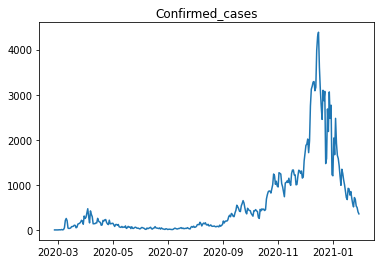

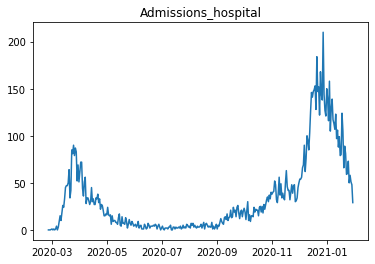

In [5]:
for observation in observations:
  plt.plot(df_obs['Date'], df_obs[observation])
  plt.title(observation)
  plt.show()

## Initialize Model Parameter

### Initialize Helper Parameter

In [6]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize to be optimized Model Parameter

In [7]:
R0_prime = initialize_prime_param('R0', device, dtype)
phi_prime = initialize_prime_param('phi', device, dtype)
sigma_prime = initialize_prime_param('sigma', device, dtype)
alpha_prime = initialize_prime_param('alpha', device, dtype)

In [8]:
dict_model_param = get_dict_model_param()
sigma_lower = dict_model_param['lower']['sigma']
sigma_upper= dict_model_param['upper']['sigma']

sigma = bij_transform(sigma_prime, sigma_lower, sigma_upper)

alpha_lower = dict_model_param['lower']['alpha']
alpha_upper= dict_model_param['upper']['alpha']

In [9]:
epsilon_t = initialize_epsilon(num_observations, sigma, dtype=dtype, device=device)

# Optimization

## Training

In [10]:
epochs = 50
params = [epsilon_t, alpha_prime]

optimizer = optim.Adam(params, lr=0.01, weight_decay=1e-8)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # forward pass
  alpha = bij_transform(alpha_prime, alpha_lower, alpha_upper)
  expected = epid_model(population, R=torch.abs(epsilon_t), initial_newly_infected=np.arange(1, 18, 3), alpha=alpha, device=device, dtype=dtype)['hospitalization']

  # calc loss
  loss = calc_mse(expected, observed)

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 5==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')


Step: 0, Time: 2.083024740219116, Loss: 2863.818115234375, Mean Expected Daily Hospit: 0.001631321618333459
Step: 5, Time: 1.3178579807281494, Loss: 2863.726806640625, Mean Expected Daily Hospit: 0.0033733604941517115
Step: 10, Time: 1.452056646347046, Loss: 2863.591064453125, Mean Expected Daily Hospit: 0.005800072569400072
Step: 15, Time: 0.6301977634429932, Loss: 2863.452880859375, Mean Expected Daily Hospit: 0.008032700046896935
Step: 20, Time: 0.6472697257995605, Loss: 2863.337890625, Mean Expected Daily Hospit: 0.009627344086766243
Step: 25, Time: 0.6506507396697998, Loss: 2863.2314453125, Mean Expected Daily Hospit: 0.010896540246903896
Step: 30, Time: 0.6409702301025391, Loss: 2863.114501953125, Mean Expected Daily Hospit: 0.012203216552734375
Step: 35, Time: 0.6540064811706543, Loss: 2862.970947265625, Mean Expected Daily Hospit: 0.013808317482471466
Step: 40, Time: 0.6418204307556152, Loss: 2862.78515625, Mean Expected Daily Hospit: 0.016010139137506485
Step: 45, Time: 0.6368

# Evaluation

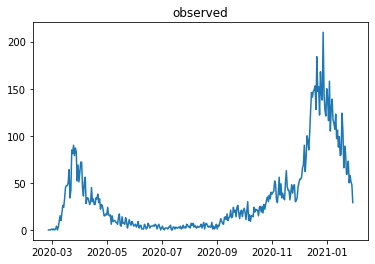

In [11]:
plt.plot(df_obs['Date'], observed.cpu().detach().numpy())
plt.title('observed')
plt.show()

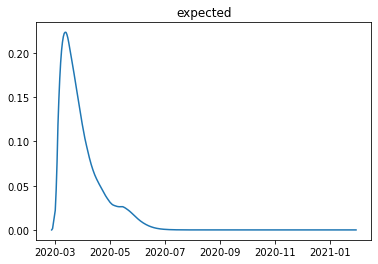

In [12]:
plt.plot(df_obs['Date'], expected.cpu().detach().numpy())
plt.title('expected')
plt.show()

In [13]:
alpha

tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)